## Exploratory Data Analysis

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import xml.etree.ElementTree as et
import pandas as pd

In [2]:
import tensorflow.keras

In [3]:
train_img_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/train")
train_annotations = sorted(glob.glob(os.path.join(train_img_path, "*.xml")))
train_images = sorted(glob.glob(os.path.join(train_img_path, "*.jpg")))

test_img_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/test")
test_annotations = sorted(glob.glob(os.path.join(test_img_path, "*.xml")))
test_images = sorted(glob.glob(os.path.join(test_img_path, "*.jpg")))

In [4]:
print(f'{len(train_annotations)} Training Annotations')
print(f'{len(train_images)} Training Images')

print(f'{len(test_annotations)} Test Annotations')
print(f'{len(test_images)} Test Images')

1512 Training Annotations
1512 Training Images
72 Test Annotations
72 Test Images


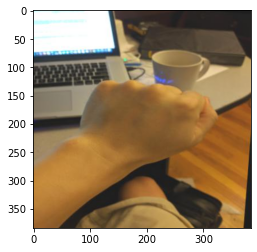

In [5]:
test_image_path = os.path.join(train_img_path,'A0_jpg.rf.292a080422ba984985192f413101af41.jpg')
test_image = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB));

### Renaming Files and Separating Images from Annotations

Here, I cleaned up the names of the files for the images and corresponding annotations, and I also separated the image files into a separate folder from the annotation files.

In [19]:
def make_new_path(img_path):
    f_type = img_path[-4:]
    
    filename = img_path.split("\\")[-1][:3]
    filename = filename.replace("_", "")
    
    new_path = "C:\\Users\\vmoha\\MPCS\\Applied Data Analysis\\Capstone\\data\\American Sign Language Letters.v1-v1.voc\\new_test_imgs\\" + filename + f_type
    
    return new_path

In [15]:
make_new_path(train_images[0]).split('.jpg')[0] + '_1' + '.jpg'

'C:\\Users\\vmoha\\MPCS\\Applied Data Analysis\\Capstone\\data\\American Sign Language Letters.v1-v1.voc\\new_test_annot\\A0_1.jpg'

In [17]:
import shutil

In [21]:
counter = 1

for src in test_images:
    dest = make_new_path(src).split('.jpg')[0] + f'_{counter}' + '.jpg'
    shutil.copyfile(src, dest)
    #print(src, dest)
    
    if counter == 3:
        counter = 1
    else:
        counter += 1
    

### Parsing XML

Each annotation file is in XML format. I first wanted to clean up/update the file name and path fields in the XML files to match the new file names.

In [6]:
train_annotations = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_train_annot")
train_images = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_train_imgs")

test_annotations = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_test_annot")
test_images = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_test_imgs")

In [7]:
for file in os.listdir(train_annotations):

    xml = et.parse(os.path.join(train_annotations, file)) 
    root = xml.getroot() 
    
    filename = file.split('.xml')[0] + '.jpg'
    root[1].text = filename
    path = "./new_train_imgs/" + filename
    root[2].text = path
    
    xml.write(train_annotations.joinpath(file))

KeyboardInterrupt: 

In [ ]:
for file in os.listdir(test_annotations):

    xml = et.parse(os.path.join(test_annotations, file)) 
    root = xml.getroot() 
    
    filename = file.split('.xml')[0] + '.jpg'
    root[1].text = filename
    path = "./new_test_imgs/" + filename
    root[2].text = path
    
    xml.write(test_annotations.joinpath(file))

The following are the important features in the XML we will want to extract:

From the XML data, we can get a quick count of the number of each letter we have in the training image data set to get an idea of what we are working with. 

In [8]:
letter_dict = {}

for file in os.listdir(train_annotations):

    xml = et.parse(os.path.join(train_annotations, file)) 
    root = xml.getroot() 
    letter = root[6][0].text
    
    if letter not in letter_dict:
        letter_dict[letter] = 1
    else:
        letter_dict[letter] += 1
    

In [9]:
letter_dict

{'A': 69,
 'B': 39,
 'C': 54,
 'D': 63,
 'E': 63,
 'F': 60,
 'G': 60,
 'H': 51,
 'I': 78,
 'J': 78,
 'K': 51,
 'L': 72,
 'M': 51,
 'N': 60,
 'O': 54,
 'P': 51,
 'Q': 60,
 'R': 48,
 'S': 69,
 'T': 42,
 'U': 48,
 'V': 57,
 'W': 57,
 'X': 63,
 'Y': 48,
 'Z': 66}

We seem to have relatively balanced classes which is good.

Here we extract the data from XML regarding the letter label, image dimensions, and bounding box coordinates and deposit into a dataframe. Each row represents an image annotation and so we also add the path to the corresponding image to each row.

In [7]:
train_image_dict = {"Image": [], 
              "Path": [],
              "Dimensions (W,H)": [],
              "Bounding_Box": [],
              "xmin": [],
              "xmax": [],
              "ymin": [],
              "ymax": [],
              "Letter": []       
             }


for file in os.listdir(train_annotations):
    row = []

    xml = et.parse(os.path.join(train_annotations, file)) 
    root = xml.getroot() 
    
    image = root[1].text
    path = root[2].text
    dimensions = int(root[4][0].text), int(root[4][1].text)
    bounding_box = [int(root[6][5][i].text) for i in range(4)]
    xmin, xmax, ymin, ymax = [int(root[6][5][i].text) for i in range(4)]
    letter = root[6][0].text
    
    for attr in image, path, dimensions, bounding_box, xmin, xmax, ymin, ymax, letter:
        row.append(attr)
    
    #print(row)
    for i,each in enumerate(train_image_dict):
        train_image_dict[each].append(row[i])
            
    
train_df = pd.DataFrame(train_image_dict)
train_df.head()

,Image,Path,"Dimensions (W,H)",Bounding_Box,xmin,xmax,ymin,ymax,Letter
0,A0_1.jpg,./new_train_imgs/A0_1.jpg,"(384, 384)","[69, 338, 110, 282]",69,338,110,282,A
1,A0_2.jpg,./new_train_imgs/A0_2.jpg,"(406, 406)","[50, 321, 112, 282]",50,321,112,282,A
2,A0_3.jpg,./new_train_imgs/A0_3.jpg,"(404, 404)","[36, 306, 114, 282]",36,306,114,282,A
3,A11_1.jpg,./new_train_imgs/A11_1.jpg,"(394, 394)","[90, 347, 132, 332]",90,347,132,332,A
4,A11_2.jpg,./new_train_imgs/A11_2.jpg,"(380, 380)","[62, 313, 139, 331]",62,313,139,331,A


In [8]:
test_image_dict = {"Image": [], 
              "Path": [],
              "Dimensions (W,H)": [],
              "Bounding_Box": [],
              "xmin": [],
              "xmax": [],
              "ymin": [],
              "ymax": [],
              "Letter": []       
             }


for file in os.listdir(test_annotations):
    row = []

    xml = et.parse(os.path.join(test_annotations, file)) 
    root = xml.getroot() 
    
    image = root[1].text
    path = root[2].text
    dimensions = int(root[4][0].text), int(root[4][1].text)
    bounding_box = [int(root[6][5][i].text) for i in range(4)]
    xmin, xmax, ymin, ymax = [int(root[6][5][i].text) for i in range(4)]
    letter = root[6][0].text
    
    for attr in image, path, dimensions, bounding_box, xmin, xmax, ymin, ymax, letter:
        row.append(attr)
    
    #print(row)
    for i,each in enumerate(test_image_dict):
        test_image_dict[each].append(row[i])
            
    
test_df = pd.DataFrame(test_image_dict)
test_df.head()

,Image,Path,"Dimensions (W,H)",Bounding_Box,xmin,xmax,ymin,ymax,Letter
0,A22_1.jpg,./new_test_imgs/A22_1.jpg,"(416, 416)","[87, 337, 103, 302]",87,337,103,302,A
1,B14_2.jpg,./new_test_imgs/B14_2.jpg,"(416, 416)","[130, 289, 102, 332]",130,289,102,332,B
2,B15_3.jpg,./new_test_imgs/B15_3.jpg,"(416, 416)","[101, 329, 70, 354]",101,329,70,354,B
3,B19_1.jpg,./new_test_imgs/B19_1.jpg,"(416, 416)","[81, 299, 25, 349]",81,299,25,349,B
4,C17_2.jpg,./new_test_imgs/C17_2.jpg,"(416, 416)","[56, 339, 110, 342]",56,339,110,342,C


In [12]:
# Adjusted from function by Claire Hester

def show_annotated_image(image_name):
    
    """This function adds annotation labels and bounding boxes to each image
    so that we can display ground truth images with annotations"""
    
    row = train_df[train_df['Image'] == image_name]
    idx = row.index
    
    image_path = os.path.join(train_images,image_name)
    
    image = cv2.imread(image_path)
    label = row['Letter'].values[0]
    print(row['Bounding_Box'].values[0])
    xmin, xmax, ymin, ymax = [int(point) for point in row["Bounding_Box"].values[0]]
    color = (0,255,0)
    
    
    cv2.rectangle(
        image,
        (xmin, ymin),
        (xmax, ymax),
        color,
        2
    )
    
    cv2.putText(image, label, (xmin-40, ymax),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 4) 

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    plt.grid(None)

[52, 260, 141, 302]


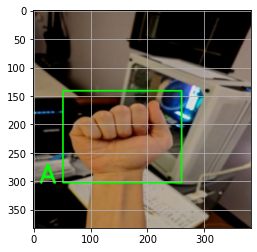

In [14]:
show_annotated_image('A1_1.jpg')

In [11]:
train_df.to_pickle('data/train_df.pkl')
test_df.to_pickle('data/test_df.pkl')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Image             1512 non-null   object
 1   Path              1512 non-null   object
 2   Dimensions (W,H)  1512 non-null   object
 3   Bounding_Box      1512 non-null   object
 4   xmin              1512 non-null   int64 
 5   xmax              1512 non-null   int64 
 6   ymin              1512 non-null   int64 
 7   ymax              1512 non-null   int64 
 8   Letter            1512 non-null   object
dtypes: int64(4), object(5)
memory usage: 106.4+ KB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Image             72 non-null     object
 1   Path              72 non-null     object
 2   Dimensions (W,H)  72 non-null     object
 3   Bounding_Box      72 non-null     object
 4   xmin              72 non-null     int64 
 5   xmax              72 non-null     int64 
 6   ymin              72 non-null     int64 
 7   ymax              72 non-null     int64 
 8   Letter            72 non-null     object
dtypes: int64(4), object(5)
memory usage: 5.2+ KB
